## Import libraries

In [33]:
import os
import sys
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm_notebook
sys.path.append('./Model')
from My_ViT import VisionTransformer, img_to_patch

In [34]:
model = torch.load('./Training/training_occlusions.pth')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print("Device:", device)
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device: mps


In [35]:
image_size = 28
embed_dim=255
hidden_dim=embed_dim*3
num_heads=3
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
dropout=0.2

## Downloading FashionMNIST from torchvision

In [36]:
# set the preprocess operations to be performed on train/val/test samples
MNIST_preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.5,), (0.5,))
                                                   ])

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/training', train=True, download=True, transform=MNIST_preprocess)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# download MNIST test set
test_set = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/testing', train=False, download=True, transform=MNIST_preprocess)

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

## Picking one test sample and running it through the first attention block

## Plotting attention

In [37]:
#ORIGINAL VISUALIZATION

test_sample_index_1 = (test_set.targets == 1).nonzero(as_tuple=True)[0][8].item()
test_sample_index_5 = (test_set.targets == 5).nonzero(as_tuple=True)[0][8].item()
test_sample_index_7 = (test_set.targets == 7).nonzero(as_tuple=True)[0][8].item()
test_sample_index_8 = (test_set.targets == 8).nonzero(as_tuple=True)[0][8].item()

img_1 = test_set.data[test_sample_index_1]
img_5 = test_set.data[test_sample_index_5]
img_7 = test_set.data[test_sample_index_7]
img_8 = test_set.data[test_sample_index_8]



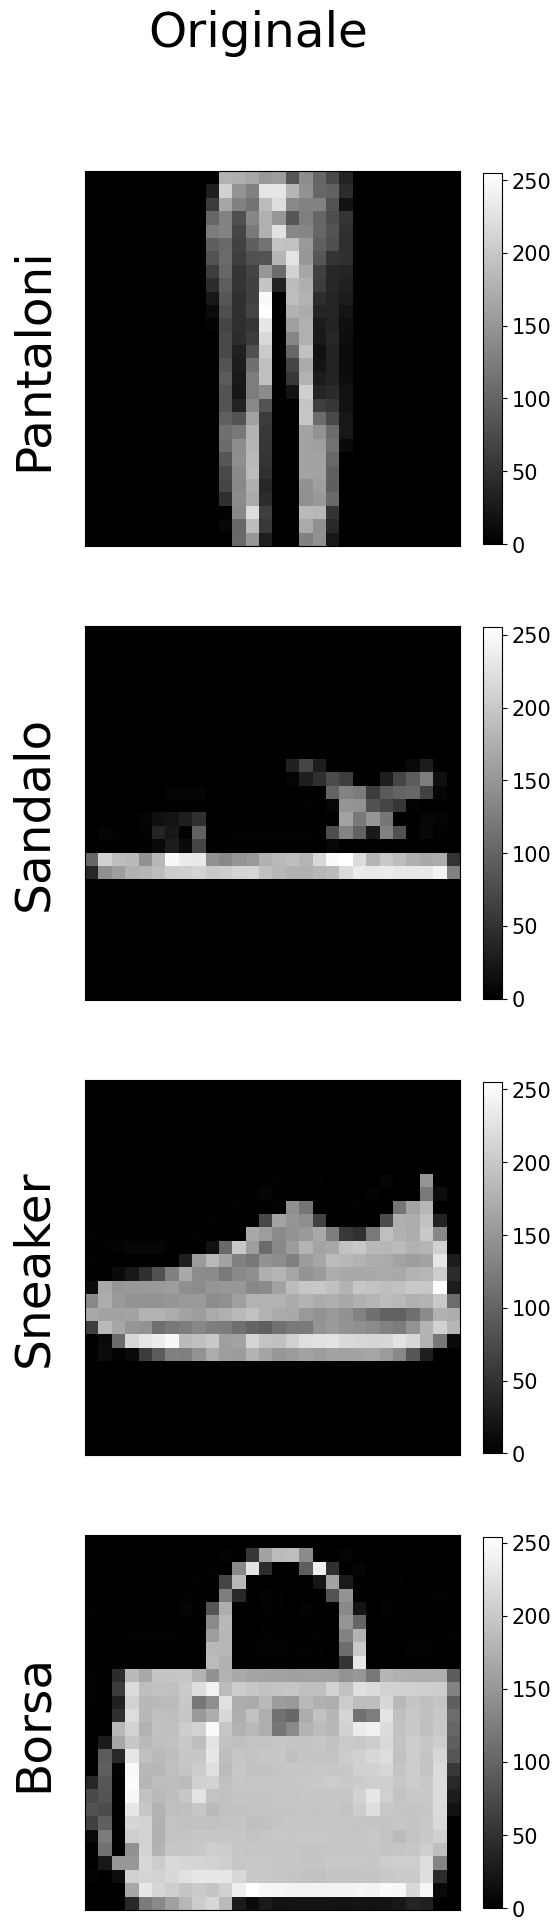

In [38]:
fontsize = 35
labelsize = 15
fig, axes = plt.subplots(4, 1, figsize=(5, 20))
fig.suptitle('Originale', fontsize=fontsize)

im1=axes[0].imshow(img_1, cmap='gray')
axes[0].text(-0.2, 0.5, 'Pantaloni', fontsize=fontsize, rotation=90, verticalalignment='center', transform=axes[0].transAxes)
axes[0].set_xticks([])
axes[0].set_yticks([])
cbar = fig.colorbar(im1, ax=axes[0], shrink=0.8)
cbar.ax.tick_params(labelsize=labelsize)  # Modifica la dimensione dei valori sulla colorbar



im2=axes[1].imshow(img_5, cmap='gray')
axes[1].text(-0.2, 0.5, 'Sandalo', fontsize=fontsize, rotation=90, verticalalignment='center', transform=axes[1].transAxes)
axes[1].set_xticks([])
axes[1].set_yticks([])
cbar = fig.colorbar(im2, ax=axes[1], shrink=0.8)
cbar.ax.tick_params(labelsize=labelsize)  # Modifica la dimensione dei valori sulla colorbar


im3=axes[2].imshow(img_7, cmap='gray')
axes[2].text(-0.2, 0.5, 'Sneaker', fontsize=fontsize, rotation=90, verticalalignment='center', transform=axes[2].transAxes)
axes[2].set_xticks([])
axes[2].set_yticks([])
cbar = fig.colorbar(im3, ax=axes[2], shrink=0.8)
cbar.ax.tick_params(labelsize=labelsize)  # Modifica la dimensione dei valori sulla colorbar



im4=axes[3].imshow(img_8, cmap='gray')
axes[3].text(-0.2, 0.5, 'Borsa', fontsize=fontsize, rotation=90, verticalalignment='center', transform=axes[3].transAxes)
axes[3].set_xticks([])
axes[3].set_yticks([])
cbar = fig.colorbar(im4, ax=axes[3], shrink=0.8)
cbar.ax.tick_params(labelsize=labelsize)  # Modifica la dimensione dei valori sulla colorbar



plt.tight_layout(rect=[0, 0, 1.13, 0.96])  # Aggiusta il layout per il titolo

plt.subplots_adjust(hspace=-0.02)  # Aumenta lo spazio verticale tra le immagini
plt.savefig('./IMAGES/originalformha.png', bbox_inches='tight', pad_inches=0.45)
plt.show()

In [39]:
def get_attention_maps (img_tensor, mode):
    img_tensor = img_tensor.to(device)
    patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
    patches = model.input_layer(patches.float())
    transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
    transformer_input_expanded = model.transformer[0].linear[0](transformer_input).squeeze(0)
    qkv = transformer_input_expanded.reshape(num_patches+1, 3, num_heads, -1)
    q = qkv[:, 0].permute(1, 0, 2)
    k = qkv[:, 1].permute(1, 0, 2)
    kT = k.permute(0, 2, 1)
    attention_matrix = q @ kT
    if mode == "mean":
        attention_matrix = torch.mean(attention_matrix, dim=0)
    elif mode == "min":
        attention_matrix, _ = torch.min(attention_matrix, dim=0)
    elif mode == "max":
        attention_matrix, _ = torch.max(attention_matrix, dim=0)

    residual_att = torch.eye(attention_matrix.size(1)).to(device)
    aug_att_mat = attention_matrix + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    attn_heatmap = aug_att_mat[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
    attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
    attn_heatmap_resized = attn_heatmap_resized - attn_heatmap_resized.min()
    attn_heatmap_resized = attn_heatmap_resized / attn_heatmap_resized.max()

    return attn_heatmap_resized


In [40]:
#MEAN

mean_attn_map_1 = get_attention_maps(img_1, mode = "mean")
mean_attn_map_5 = get_attention_maps(img_5, mode = "mean")
mean_attn_map_7 = get_attention_maps(img_7, mode = "mean")
mean_attn_map_8 = get_attention_maps(img_8, mode = "mean")

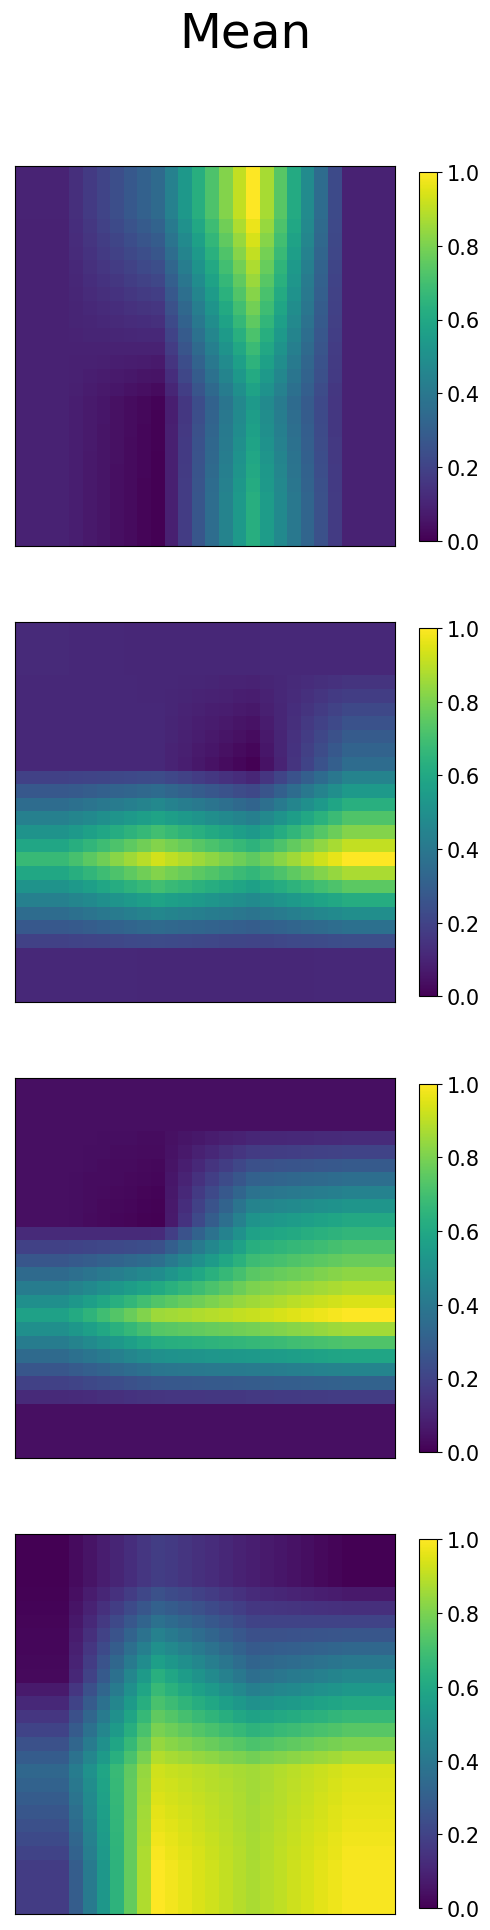

In [41]:
fig, axes = plt.subplots(4, 1, figsize=(5, 20))
fig.suptitle('Mean', fontsize=fontsize)

im1 = axes[0].imshow(mean_attn_map_1.detach().cpu().numpy(), cmap='viridis')
axes[0].set_xticks([])
axes[0].set_yticks([])
cbar = fig.colorbar(im1, ax=axes[0], shrink=0.8)
cbar.ax.tick_params(labelsize=labelsize)  # Modifica la dimensione dei valori sulla colorbar


im2 = axes[1].imshow(mean_attn_map_5.detach().cpu().numpy(), cmap='viridis')
axes[1].set_xticks([])
axes[1].set_yticks([])
cbar = fig.colorbar(im2, ax=axes[1], shrink=0.8)
cbar.ax.tick_params(labelsize=labelsize)  # Modifica la dimensione dei valori sulla colorbar


im3 = axes[2].imshow(mean_attn_map_7.detach().cpu().numpy(), cmap='viridis')
axes[2].set_xticks([])
axes[2].set_yticks([])
cbar = fig.colorbar(im3, ax=axes[2], shrink=0.8)
cbar.ax.tick_params(labelsize=labelsize)  # Modifica la dimensione dei valori sulla colorbar


im4 = axes[3].imshow(mean_attn_map_8.detach().cpu().numpy(), cmap='viridis')
axes[3].set_xticks([])
axes[3].set_yticks([])
cbar = fig.colorbar(im4, ax=axes[3], shrink=0.8)
cbar.ax.tick_params(labelsize=labelsize)  # Modifica la dimensione dei valori sulla colorbar


plt.tight_layout(rect=[0, 0, 1.02, 0.96])  # Aggiusta il layout per il titolo
plt.show()

In [42]:
min_attn_map_1 = get_attention_maps(img_1, mode="min")
min_attn_map_5 = get_attention_maps(img_5, mode="min")
min_attn_map_7 = get_attention_maps(img_7, mode="min")
min_attn_map_8 = get_attention_maps(img_8, mode="min")

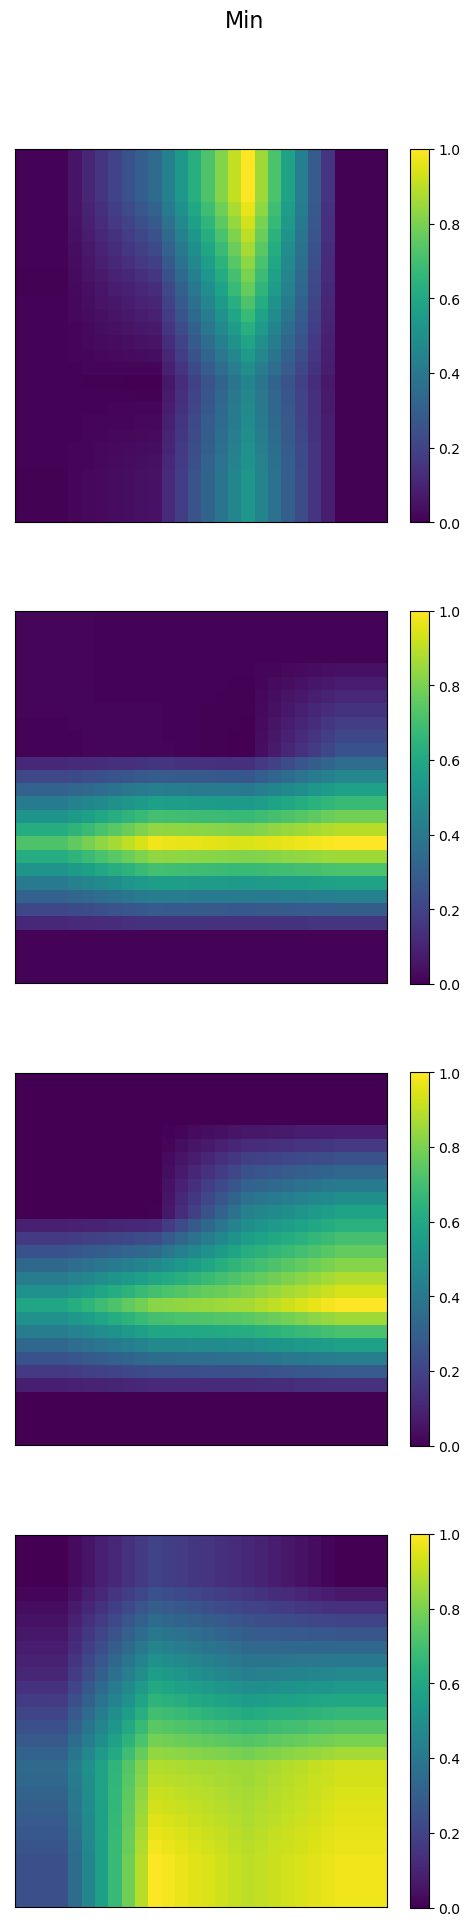

In [43]:
fig, axes = plt.subplots(4, 1, figsize=(5, 20))
fig.suptitle('Min', fontsize=16)

im1 = axes[0].imshow(min_attn_map_1.detach().cpu().numpy(), cmap='viridis')
axes[0].set_xticks([])
axes[0].set_yticks([])
fig.colorbar(im1, ax=axes[0], shrink=0.8)

im2 = axes[1].imshow(min_attn_map_5.detach().cpu().numpy(), cmap='viridis')
axes[1].set_xticks([])
axes[1].set_yticks([])
fig.colorbar(im2, ax=axes[1], shrink=0.8)

im3 = axes[2].imshow(min_attn_map_7.detach().cpu().numpy(), cmap='viridis')
axes[2].set_xticks([])
axes[2].set_yticks([])
fig.colorbar(im3, ax=axes[2], shrink=0.8)

im4 = axes[3].imshow(min_attn_map_8.detach().cpu().numpy(), cmap='viridis')
axes[3].set_xticks([])
axes[3].set_yticks([])
fig.colorbar(im4, ax=axes[3], shrink=0.8)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Aggiusta il layout per il titolo
plt.show()

In [44]:
max_attn_map_1 = get_attention_maps(img_1, mode="max")
max_attn_map_5 = get_attention_maps(img_5, mode="max")
max_attn_map_7 = get_attention_maps(img_7, mode="max")
max_attn_map_8 = get_attention_maps(img_8, mode="max")

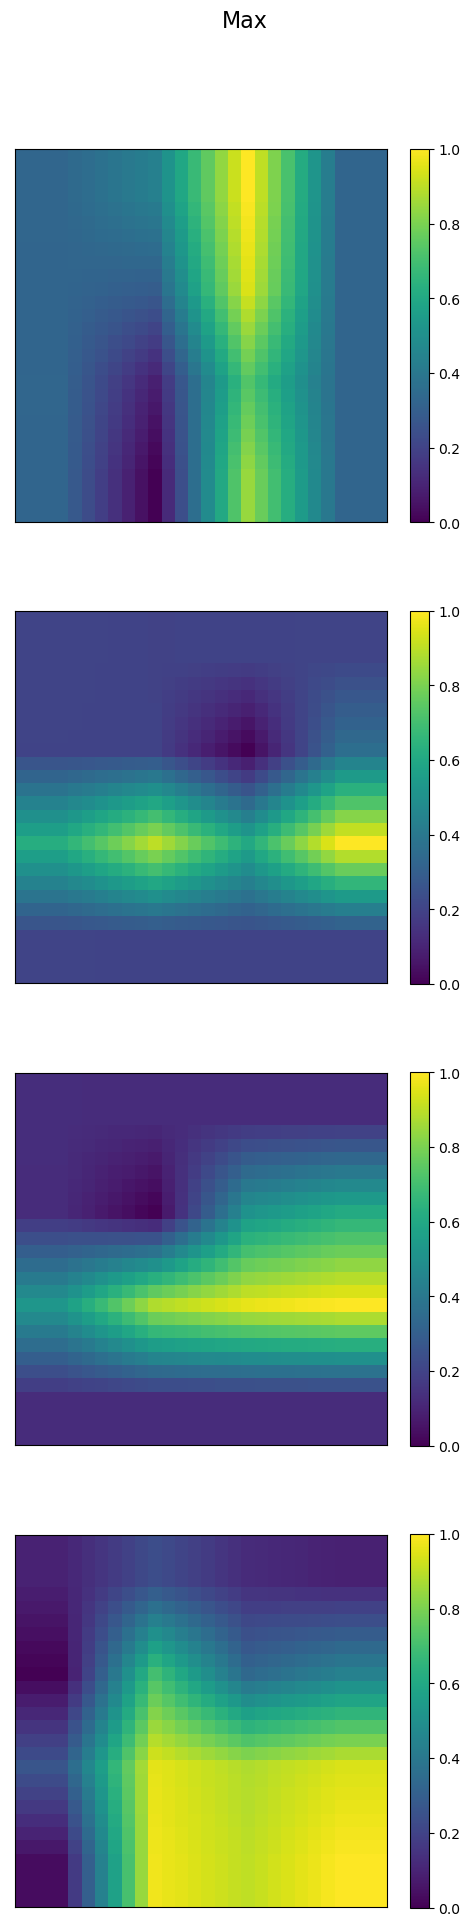

In [45]:
fig, axes = plt.subplots(4, 1, figsize=(5, 20))
fig.suptitle('Max', fontsize=16)

im1 = axes[0].imshow(max_attn_map_1.detach().cpu().numpy(), cmap='viridis')
axes[0].set_xticks([])
axes[0].set_yticks([])
fig.colorbar(im1, ax=axes[0], shrink=0.8)

im2 = axes[1].imshow(max_attn_map_5.detach().cpu().numpy(), cmap='viridis')
axes[1].set_xticks([])
axes[1].set_yticks([])
fig.colorbar(im2, ax=axes[1], shrink=0.8)

im3 = axes[2].imshow(max_attn_map_7.detach().cpu().numpy(), cmap='viridis')
axes[2].set_xticks([])
axes[2].set_yticks([])
fig.colorbar(im3, ax=axes[2], shrink=0.8)

im4 = axes[3].imshow(max_attn_map_8.detach().cpu().numpy(), cmap='viridis')
axes[3].set_xticks([])
axes[3].set_yticks([])
fig.colorbar(im4, ax=axes[3], shrink=0.8)


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Aggiusta il layout per il titolo
plt.show()



In [46]:
#ROLLOUT

def attention_rollout_function(attn_maps):
    attn_rollout = []
    I = torch.eye(attn_maps[0].shape[-1]).to(attn_maps[0].device)
    prod = I
    for i, attn_map in enumerate(attn_maps):
        prod = prod @ (attn_map + I)  
        
        prod = prod / prod.sum(dim=-1, keepdim=True) 
        attn_rollout.append(prod)
    return attn_rollout

In [47]:
def get_attention_maps (img_tensor):
    img_tensor = img_tensor.to(device)
    patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
    patches = model.input_layer(patches.float())
    transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
    attn_maps = []
    for block in model.transformer:
        transformer_input_expanded = block.linear[0](transformer_input).squeeze(0)
        qkv = transformer_input_expanded.reshape(num_patches + 1, 3, -1, num_heads).permute(1, 3, 0, 2)
        q = qkv[0]
        k = qkv[1]
        kT = k.transpose(-2, -1)
        attention_matrices = torch.matmul(q, kT)
        avg_attention = attention_matrices.mean(dim=0)
        attn_maps.append(avg_attention)
    rollout_matrices = attention_rollout_function(attn_maps)
    last_rollout = rollout_matrices[-1]
    attn_heatmap = last_rollout[0, 1:].reshape((int(image_size / patch_size), int(image_size / patch_size)))
    attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
    attn_heatmap_resized = attn_heatmap_resized - attn_heatmap_resized.min()
    attn_heatmap_resized = attn_heatmap_resized / attn_heatmap_resized.max()

    return attn_heatmap_resized
   

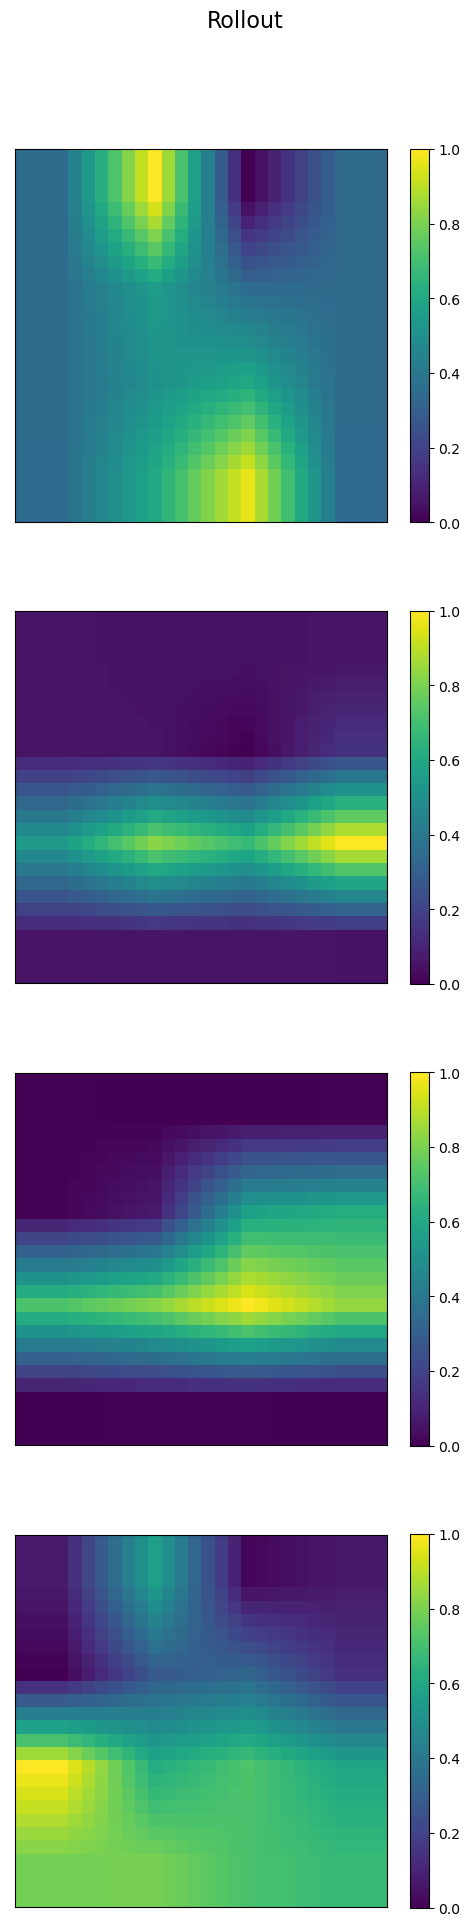

In [48]:
rollout_attn_map_1 = get_attention_maps(img_1)
rollout_attn_map_5 = get_attention_maps(img_5)
rollout_attn_map_7 = get_attention_maps(img_7)
rollout_attn_map_8 = get_attention_maps(img_8)

fig, axes = plt.subplots(4, 1, figsize=(5, 20))
fig.suptitle('Rollout', fontsize=16)

im1 = axes[0].imshow(rollout_attn_map_1.detach().cpu().numpy(), cmap='viridis')
axes[0].set_xticks([])
axes[0].set_yticks([])
fig.colorbar(im1, ax=axes[0], shrink=0.8)

im2 = axes[1].imshow(rollout_attn_map_5.detach().cpu().numpy(), cmap='viridis')
axes[1].set_xticks([])
axes[1].set_yticks([])
fig.colorbar(im2, ax=axes[1], shrink=0.8)

im3 = axes[2].imshow(rollout_attn_map_7.detach().cpu().numpy(), cmap='viridis')
axes[2].set_xticks([])
axes[2].set_yticks([])
fig.colorbar(im3, ax=axes[2], shrink=0.8)

im4 = axes[3].imshow(rollout_attn_map_8.detach().cpu().numpy(), cmap='viridis')
axes[3].set_xticks([])
axes[3].set_yticks([])
fig.colorbar(im4, ax=axes[3], shrink=0.8)


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Aggiusta il layout per il titolo
plt.savefig('./IMAGES/rolloutformha_attention_maps.png')
plt.show()



In [49]:
#MULTIPLE HEADS

def get_attention_maps (img_tensor, ylabel, title, item):
    img_tensor = img_tensor.to(device)
    patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
    patches = model.input_layer(patches.float())
    transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
    transformer_input_expanded = model.transformer[0].linear[0](transformer_input).squeeze(0)
    qkv = transformer_input_expanded.reshape(num_patches + 1, 3, -1, num_heads).permute(1, 3, 0, 2)
    q = qkv[0] 
    k = qkv[1]
    kT = k.transpose(-2, -1)
    attention_matrices = torch.matmul(q, kT)
    residual_att = torch.eye(attention_matrices.size(-1)).to(device)
    aug_att_mats = attention_matrices + residual_att
    aug_att_mats = aug_att_mats / aug_att_mats.sum(dim=-1).unsqueeze(-1)

    #for the mean
    attention_matrix_mean = torch.mean(attention_matrices, dim=0)
    residual_att_mean = torch.eye(attention_matrix_mean.size(-1)).to(device)
    aug_att_mat_mean = attention_matrix_mean + residual_att_mean
    aug_att_mat_mean = aug_att_mat_mean / aug_att_mat_mean.sum(dim=-1).unsqueeze(-1)
    attn_heatmap_mean = aug_att_mat_mean[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
    attn_heatmap_resized_mean = F.interpolate(attn_heatmap_mean.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
    
    #original + heatmaps per ogni head
    fig, axes = plt.subplots(1, 5, figsize=(30, 6))
    img = np.asarray(img_tensor.cpu())
    axes[0].imshow(img, cmap='gray')
    if title is not None:
        axes[0].set_title('Original')
    axes[0].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    axes[0].set_ylabel(ylabel, fontsize=12)

    fig.colorbar(axes[0].images[0], ax=axes[0], shrink=0.65)

    for i in range(3):  # Le prime 3 heads
        attn_heatmap = aug_att_mats[i, 0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
        attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
        attn_heatmap_resized = attn_heatmap_resized - attn_heatmap_resized.min()
        attn_heatmap_resized = attn_heatmap_resized / attn_heatmap_resized.max()

        axes[i + 1].imshow(attn_heatmap_resized.detach().cpu().numpy())
        if title is not None:
            axes[i + 1].set_title(f'Attention head {i + 1}')
        axes[i + 1].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        fig.colorbar(axes[i + 1].images[0], ax=axes[i + 1], shrink=0.65)
    im4= axes[4].imshow(attn_heatmap_resized_mean.detach().cpu().numpy(), cmap='viridis')
    if title is not None:
        axes[4].set_title(f'Mean')
    axes[4].set_xticks([])
    axes[4].set_yticks([])
    fig.colorbar(im4, ax=axes[4], shrink=0.65)
    for ax in axes[1:]:
        for im in ax.get_images():
            im.colorbar.formatter.set_powerlimits((0, 0))
            im.colorbar.formatter.set_scientific(True)
            im.colorbar.formatter.set_useOffset(False)
            im.colorbar.formatter.set_useMathText(True)
            im.colorbar.update_ticks()
            im.colorbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))
            im.colorbar.set_ticks(np.linspace(im.colorbar.vmin, im.colorbar.vmax, num=6))

    plt.savefig(f'./IMAGES/{item}.png')
    plt.show()

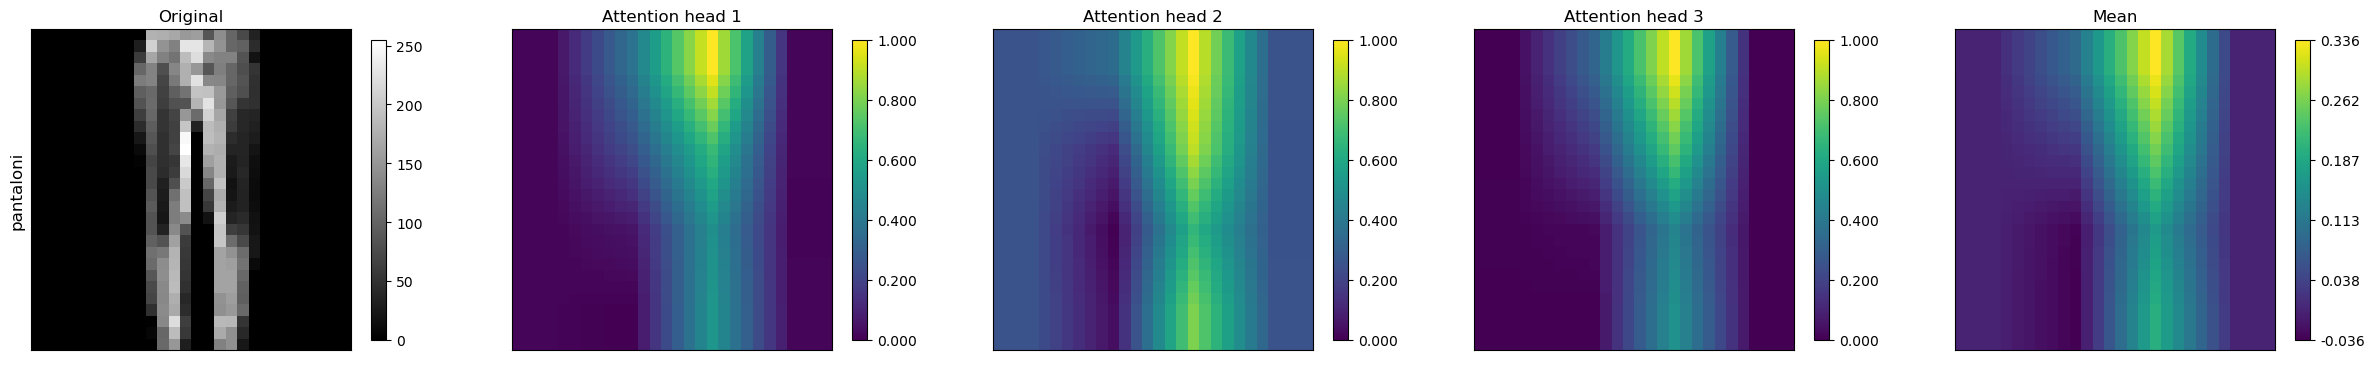

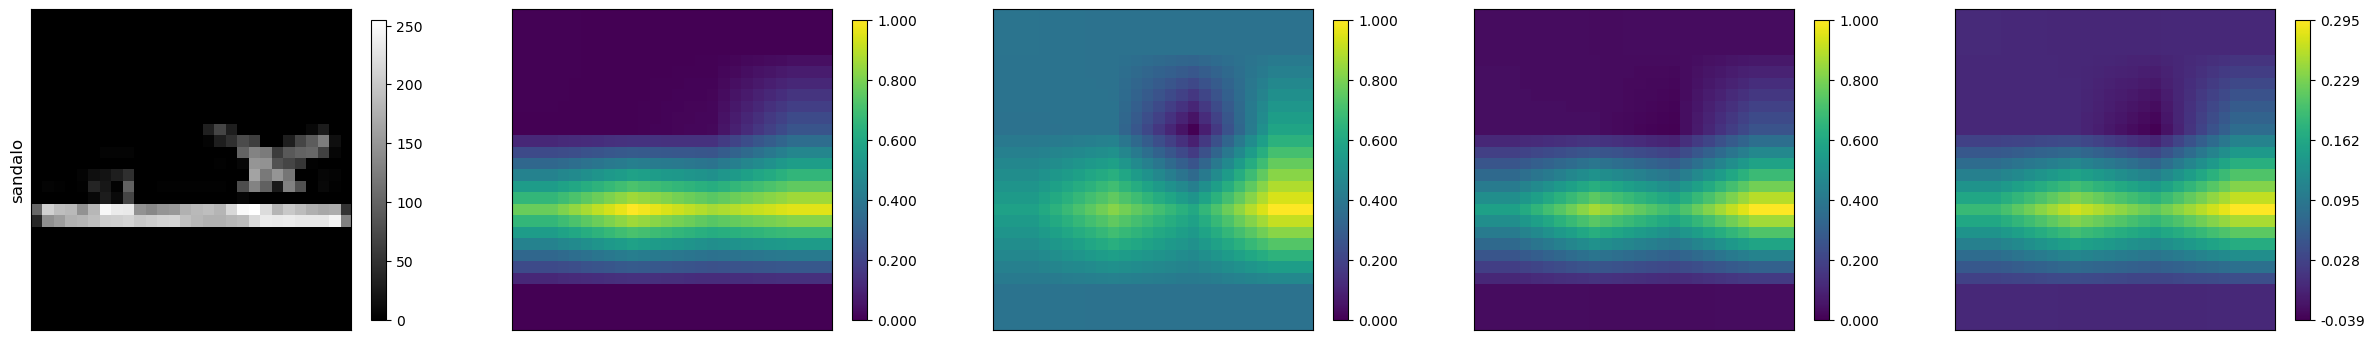

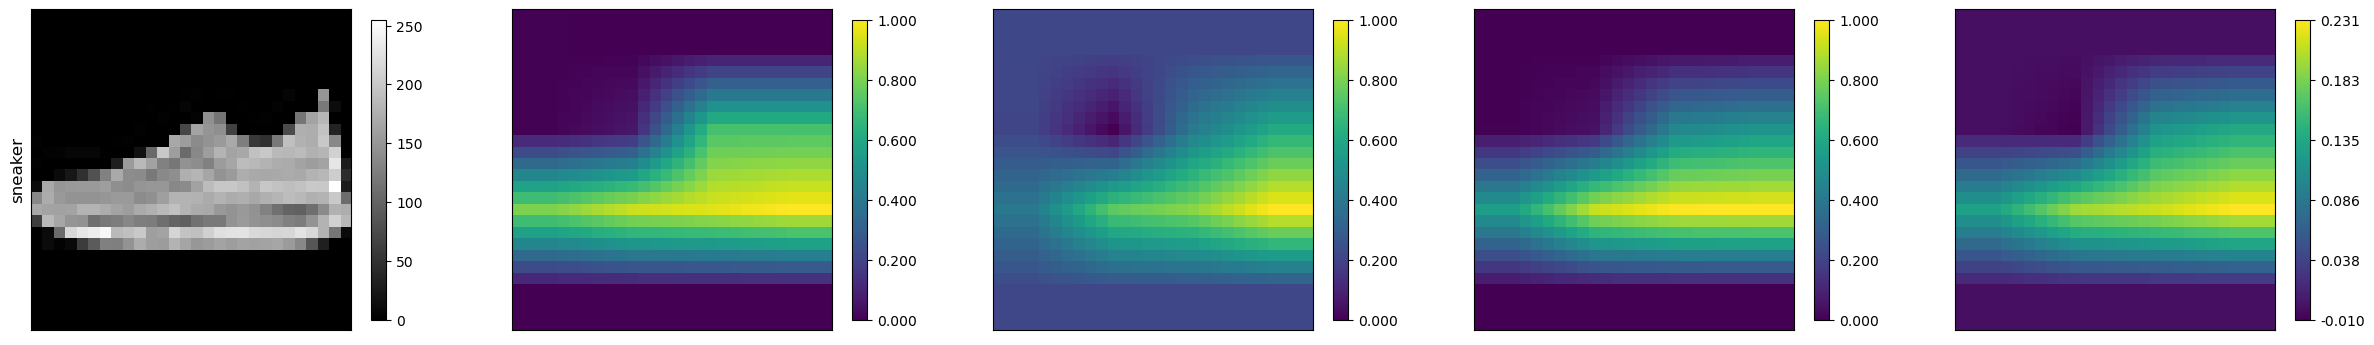

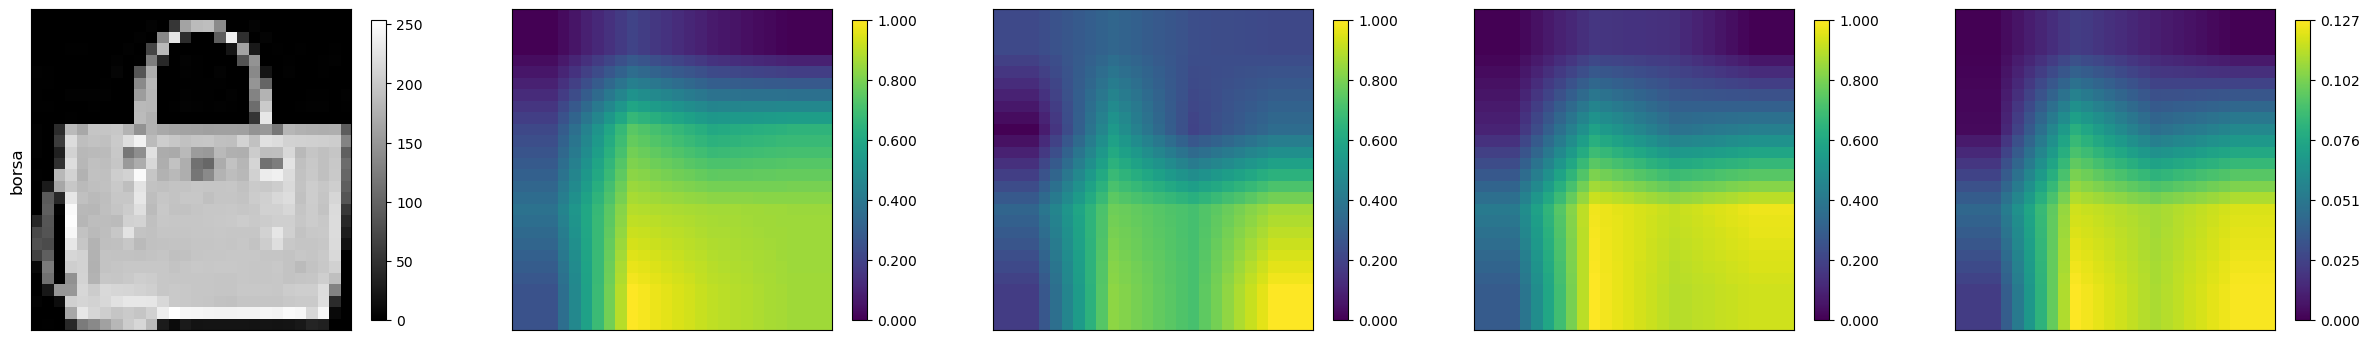

In [50]:
get_attention_maps(img_1, 'pantaloni', title = 'pantaloni', item='pantaloni_multihead')
get_attention_maps(img_5, 'sandalo', title=None, item='sandalo_multihead')
get_attention_maps(img_7, 'sneaker', title=None, item='sneaker_multihead')
get_attention_maps(img_8, 'borsa', title=None, item='borsa_multihead')

In [51]:
def plot_first_attention_head(images, head):
    fig, axes = plt.subplots(4, 1, figsize=(5, 20))
    fig.suptitle(f'head {head+1}', fontsize=fontsize)
    for i, img_tensor in enumerate (images):
        img_tensor = img_tensor.to(device)
        patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
        patches = model.input_layer(patches.float())
        transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
        transformer_input_expanded = model.transformer[0].linear[0](transformer_input).squeeze(0)
        qkv = transformer_input_expanded.reshape(num_patches + 1, 3, -1, num_heads).permute(1, 3, 0, 2)
        q = qkv[0]
        k = qkv[1]
        kT = k.transpose(-2, -1)
        attention_matrices = torch.matmul(q, kT)
        residual_att = torch.eye(attention_matrices.size(-1)).to(device)
        aug_att_mats = attention_matrices + residual_att
        aug_att_mats = aug_att_mats / aug_att_mats.sum(dim=-1).unsqueeze(-1)
        attn_heatmap = aug_att_mats[head, 0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
        attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
        attn_heatmap_resized = attn_heatmap_resized - attn_heatmap_resized.min()
        attn_heatmap_resized = attn_heatmap_resized / attn_heatmap_resized.max()

        heatmap = axes[i].imshow(attn_heatmap_resized.detach().cpu().numpy(), cmap='viridis')
        axes[i].axis('off')
        cbar = fig.colorbar(heatmap, ax=axes[i], fraction=0.046, pad=0.04, format='%.2f')
        cbar.ax.tick_params(labelsize=labelsize)  # Modifica la dimensione dei valori sulla colorbar

    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Aggiusta il layout per il titolo
    plt.savefig(f'./IMAGES/MHA/head {head + 1}.png')
    return fig


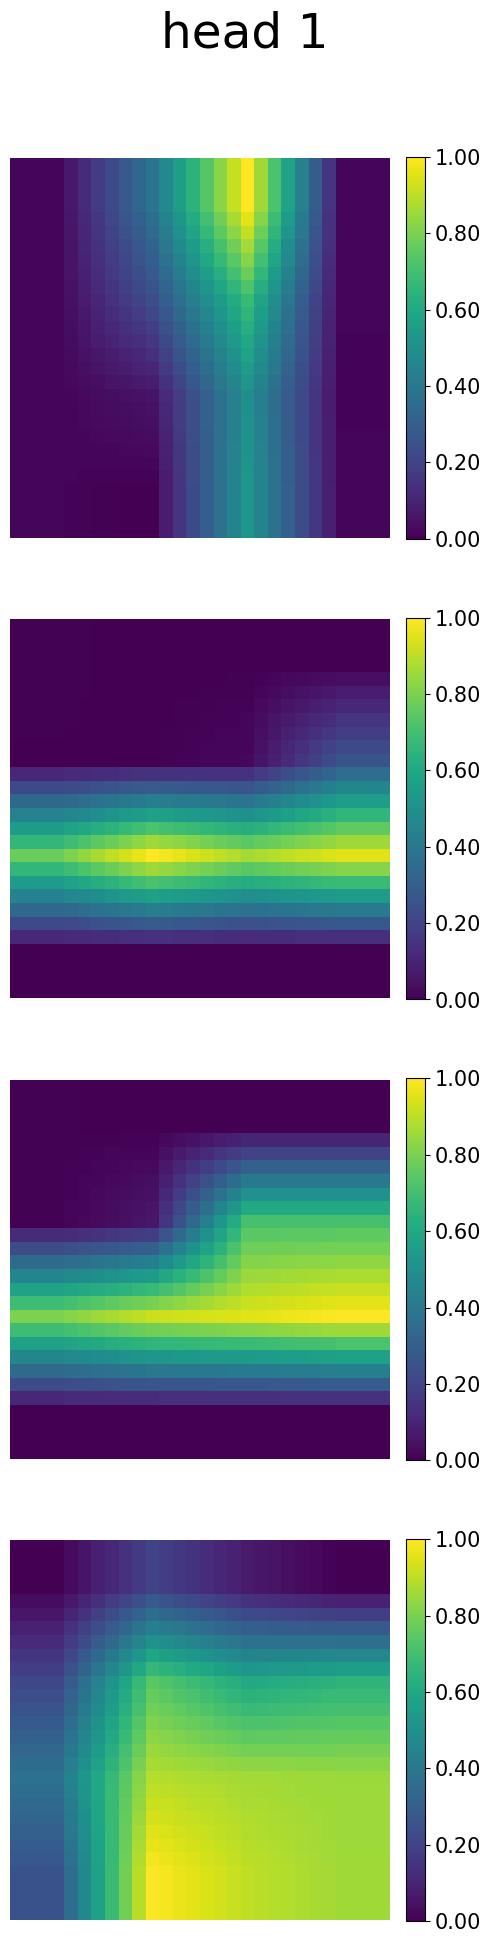

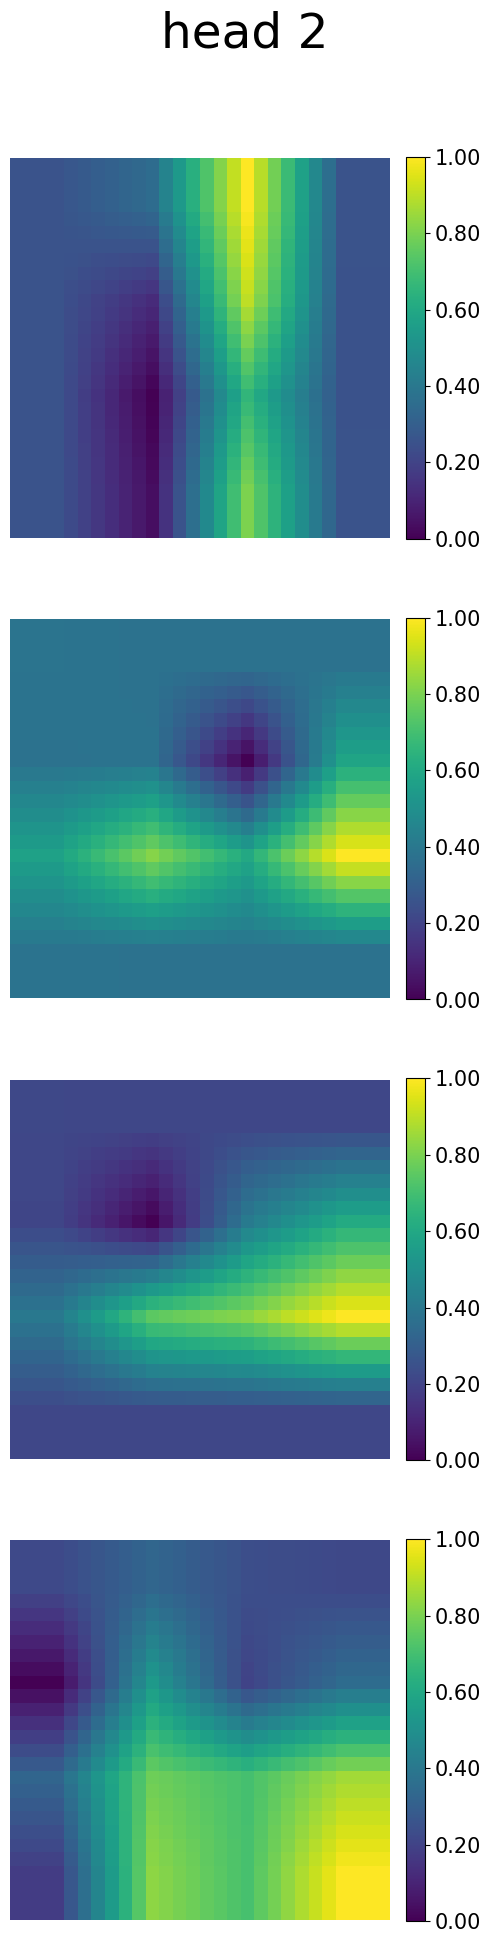

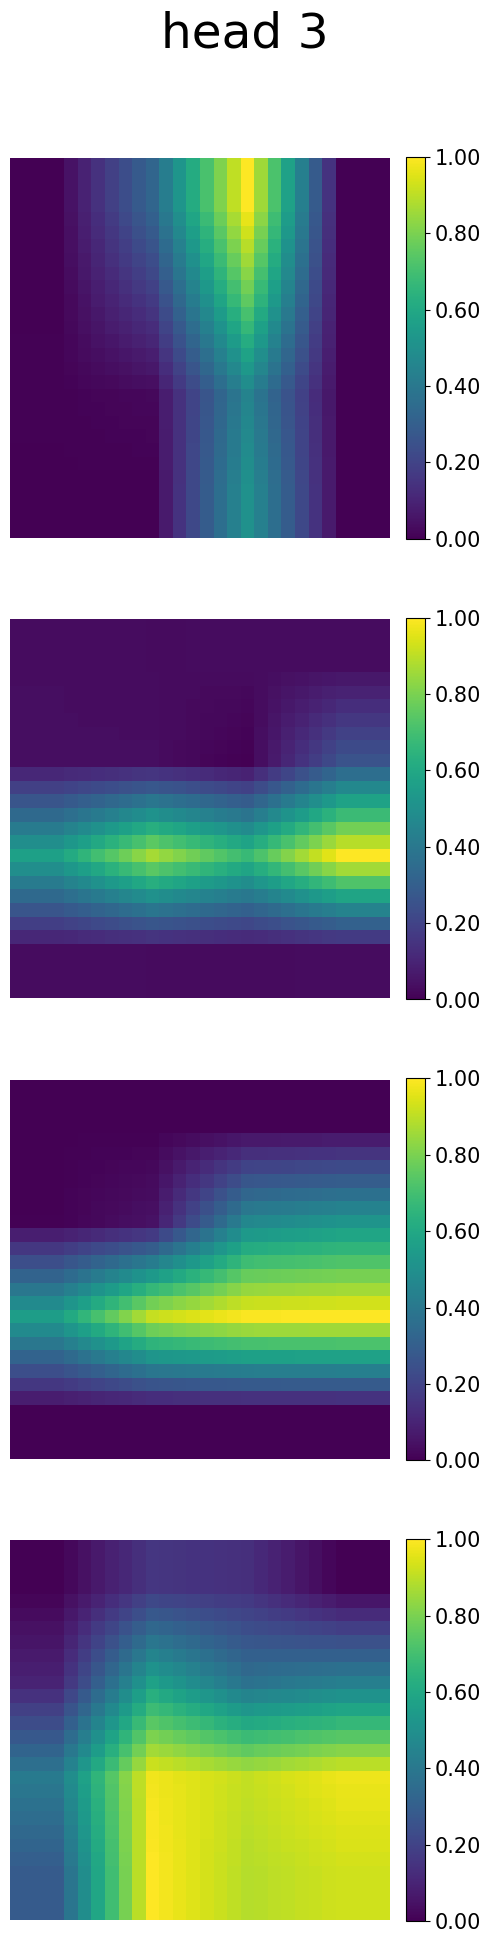

In [52]:
imgs = [img_1, img_5, img_7, img_8]  
head_1 = plot_first_attention_head(imgs, head=0)
head_2 = plot_first_attention_head(imgs, head=1)
head_3 = plot_first_attention_head(imgs, head=2)

In [53]:
def plot_first_attention_head(images, head):
    fig, axes = plt.subplots(4, 1, figsize=(5, 20))
    fig.suptitle(f'head {head+1}', fontsize=fontsize)
    for i, img_tensor in enumerate (images):
        img_tensor = img_tensor.to(device)
        patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
        patches = model.input_layer(patches.float())
        transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
        transformer_input_expanded = model.transformer[0].linear[0](transformer_input).squeeze(0)
        qkv = transformer_input_expanded.reshape(num_patches + 1, 3, -1, num_heads).permute(1, 3, 0, 2)
        q = qkv[0]
        k = qkv[1]
        kT = k.transpose(-2, -1)
        attention_matrices = torch.matmul(q, kT)
        residual_att = torch.eye(attention_matrices.size(-1)).to(device)
        aug_att_mats = attention_matrices + residual_att
        aug_att_mats = aug_att_mats / aug_att_mats.sum(dim=-1).unsqueeze(-1)
        attn_heatmap = aug_att_mats[head, 0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
        attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
        attn_heatmap_resized = attn_heatmap_resized - attn_heatmap_resized.min()
        attn_heatmap_resized = attn_heatmap_resized / attn_heatmap_resized.max()

        heatmap = axes[i].imshow(attn_heatmap_resized.detach().cpu().numpy(), cmap='viridis')
        axes[i].axis('off')
        cbar = fig.colorbar(heatmap, ax=axes[i], fraction=0.046, pad=0.04, format='%.2f')
        cbar.ax.tick_params(labelsize=labelsize)  # Modifica la dimensione dei valori sulla colorbar

    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Aggiusta il layout per il titolo
    return fig
    

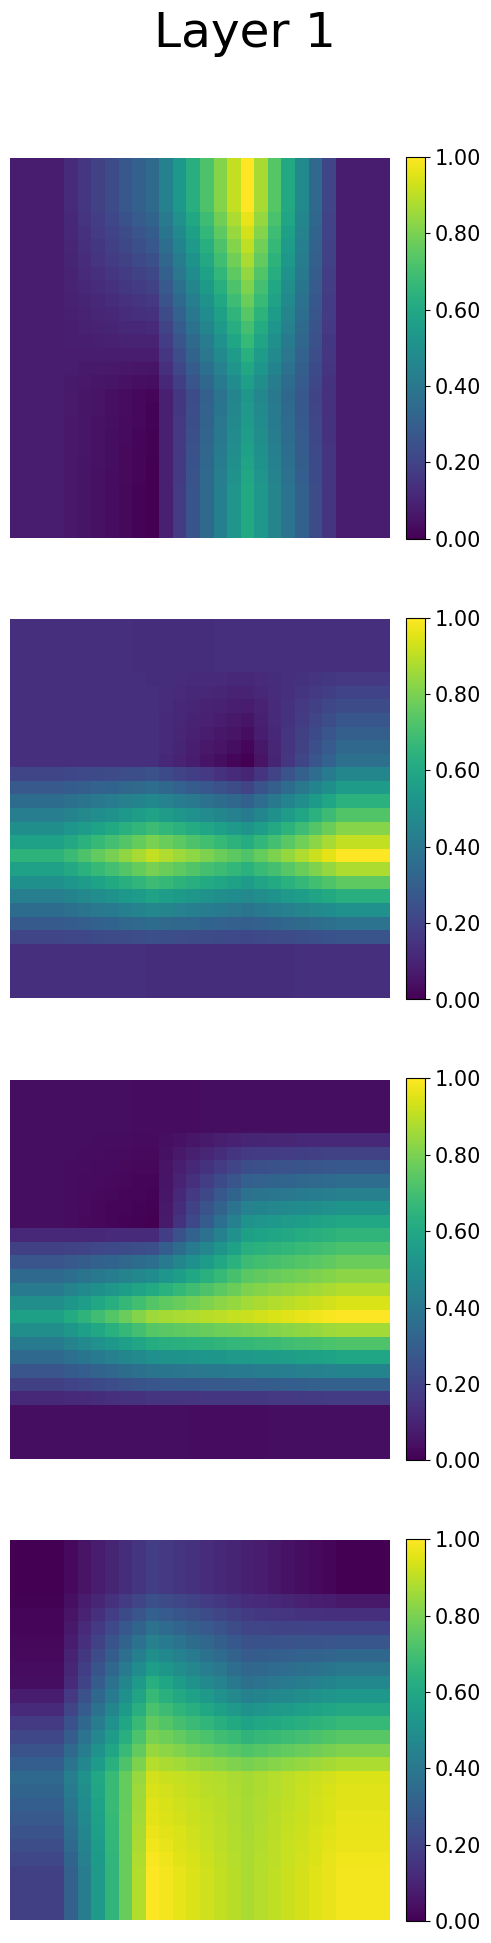

In [62]:
def get_attention_maps_for_heads(img_tensor):
    img_tensor = img_tensor.to(device)
    patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
    patches = model.input_layer(patches.float())
    transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
    transformer_input_expanded = model.transformer[0].linear[0](transformer_input).squeeze(0)
    qkv = transformer_input_expanded.reshape(num_patches + 1, 3, -1, num_heads).permute(1, 3, 0, 2)
    q = qkv[0]
    k = qkv[1]
    kT = k.transpose(-2, -1)
    attention_matrices = torch.matmul(q, kT)
    residual_att = torch.eye(attention_matrices.size(-1)).to(device)
    aug_att_mats = attention_matrices + residual_att
    aug_att_mats = aug_att_mats / aug_att_mats.sum(dim=-1).unsqueeze(-1)
    
    attn_heatmaps = []
    for head in range(num_heads):
        attn_heatmap = aug_att_mats[head, 0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
        attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
        attn_heatmap_resized = attn_heatmap_resized - attn_heatmap_resized.min()
        attn_heatmap_resized = attn_heatmap_resized / attn_heatmap_resized.max()
        attn_heatmaps.append(attn_heatmap_resized)
    
    return attn_heatmaps

def plot_mean_attention_maps(images):
    fig, axes = plt.subplots(4, 1, figsize=(5, 20))
    fig.suptitle('Layer 1', fontsize=fontsize)
    
    for i, img_tensor in enumerate(images):
        attn_heatmaps = get_attention_maps_for_heads(img_tensor)
        mean_attn_heatmap = torch.mean(torch.stack(attn_heatmaps), dim=0)
        mean_attn_heatmap = (mean_attn_heatmap - mean_attn_heatmap.min()) / (mean_attn_heatmap.max() - mean_attn_heatmap.min())
        heatmap = axes[i].imshow(mean_attn_heatmap.detach().cpu().numpy(), cmap='viridis')
        axes[i].axis('off')
        cbar = fig.colorbar(heatmap, ax=axes[i], fraction=0.046, pad=0.04, format='%.2f')
        cbar.ax.tick_params(labelsize=labelsize)  # Modifica la dimensione dei valori sulla colorbar
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Aggiusta il layout per il titolo
    plt.savefig('./IMAGES/mean')
    plt.show()

imgs = [img_1, img_5, img_7, img_8]
plot_mean_attention_maps(imgs)

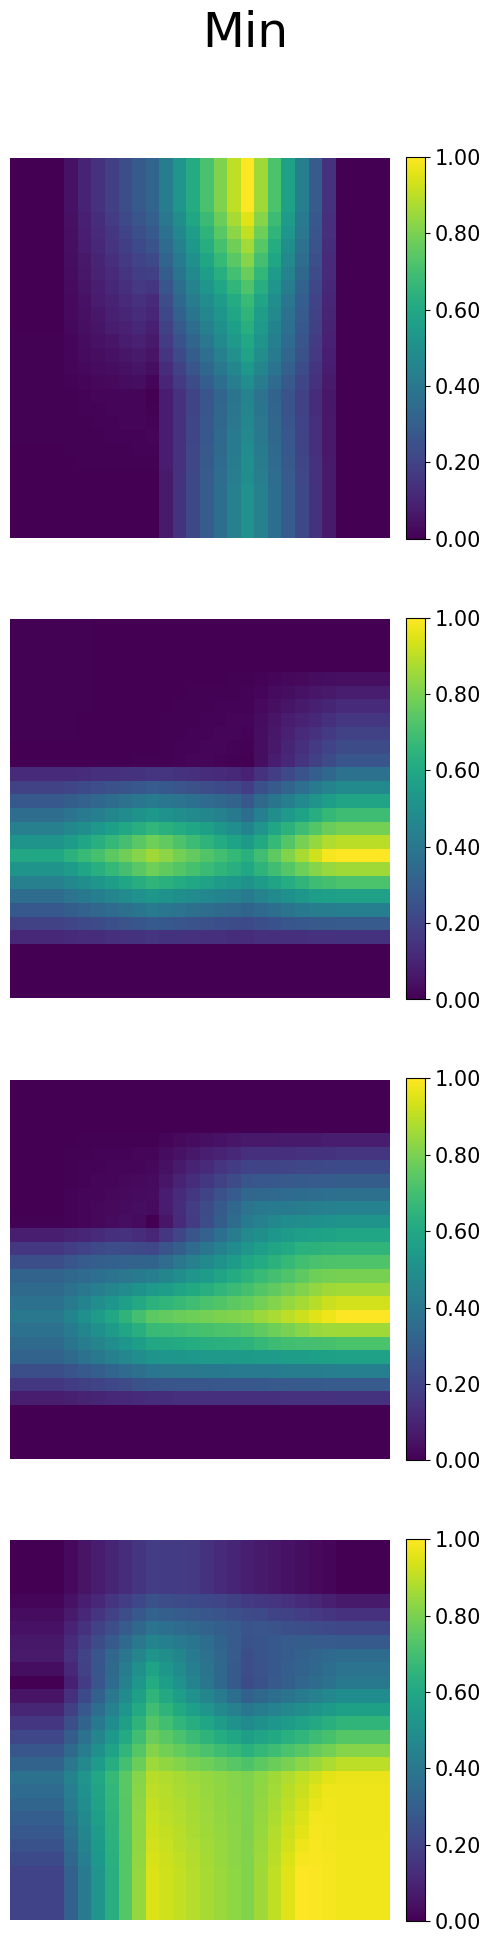

In [58]:
def get_attention_maps_for_heads(img_tensor):
    img_tensor = img_tensor.to(device)
    patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
    patches = model.input_layer(patches.float())
    transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
    transformer_input_expanded = model.transformer[0].linear[0](transformer_input).squeeze(0)
    qkv = transformer_input_expanded.reshape(num_patches + 1, 3, -1, num_heads).permute(1, 3, 0, 2)
    q = qkv[0]
    k = qkv[1]
    kT = k.transpose(-2, -1)
    attention_matrices = torch.matmul(q, kT)
    residual_att = torch.eye(attention_matrices.size(-1)).to(device)
    aug_att_mats = attention_matrices + residual_att
    aug_att_mats = aug_att_mats / aug_att_mats.sum(dim=-1).unsqueeze(-1)
    
    attn_heatmaps = []
    for head in range(num_heads):
        attn_heatmap = aug_att_mats[head, 0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
        attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
        attn_heatmap_resized = attn_heatmap_resized - attn_heatmap_resized.min()
        attn_heatmap_resized = attn_heatmap_resized / attn_heatmap_resized.max()
        attn_heatmaps.append(attn_heatmap_resized)
    
    return attn_heatmaps

def plot_min_attention_maps(images):
    fig, axes = plt.subplots(4, 1, figsize=(5, 20))
    fig.suptitle('Min', fontsize=fontsize)
    
    for i, img_tensor in enumerate(images):
        attn_heatmaps = get_attention_maps_for_heads(img_tensor)
        min_attn_heatmap = torch.min(torch.stack(attn_heatmaps), dim=0).values
        min_attn_heatmap = (min_attn_heatmap - min_attn_heatmap.min()) / (min_attn_heatmap.max() - min_attn_heatmap.min())
        heatmap = axes[i].imshow(min_attn_heatmap.detach().cpu().numpy(), cmap='viridis')
        axes[i].axis('off')
        cbar = fig.colorbar(heatmap, ax=axes[i], fraction=0.046, pad=0.04, format='%.2f')
        cbar.ax.tick_params(labelsize=labelsize)  # Modifica la dimensione dei valori sulla colorbar
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Aggiusta il layout per il titolo
    plt.savefig('./IMAGES/min')

    plt.show()

imgs = [img_1, img_5, img_7, img_8]
plot_min_attention_maps(imgs)

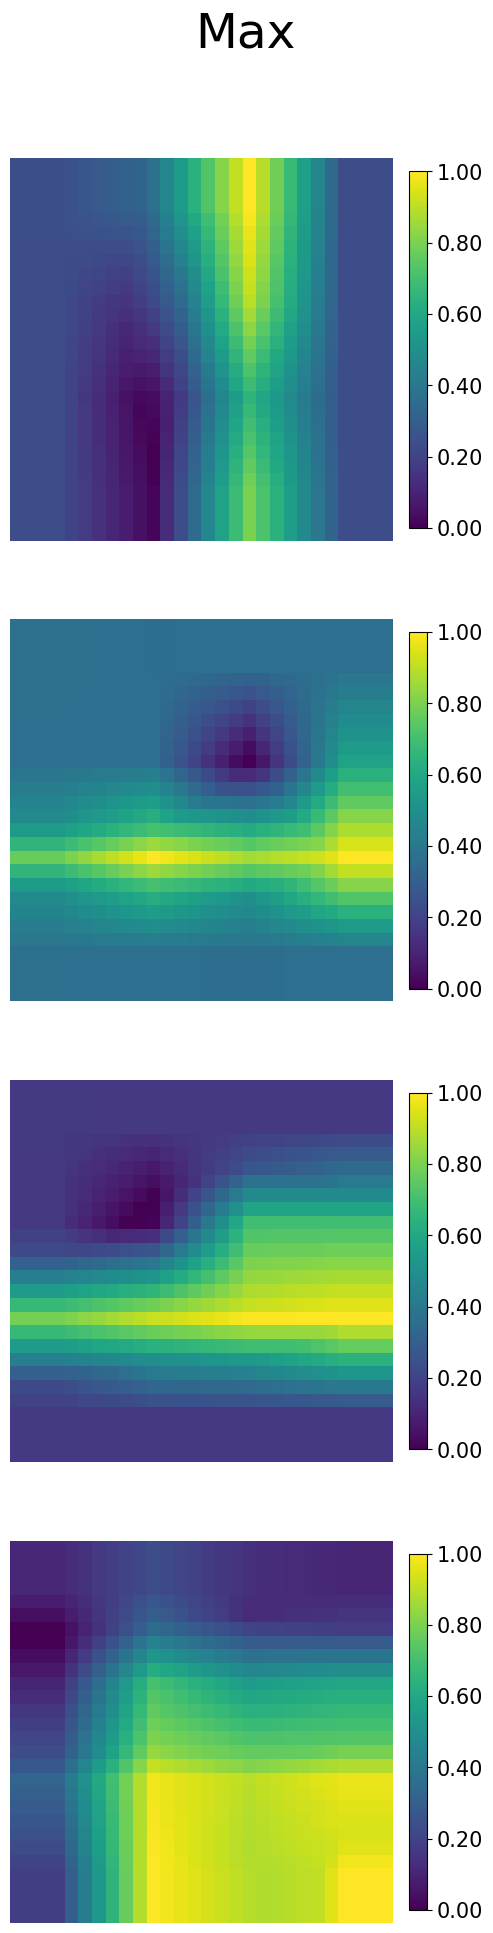

In [60]:
def get_attention_maps_for_heads(img_tensor):
    img_tensor = img_tensor.to(device)
    patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
    patches = model.input_layer(patches.float())
    transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
    transformer_input_expanded = model.transformer[0].linear[0](transformer_input).squeeze(0)
    qkv = transformer_input_expanded.reshape(num_patches + 1, 3, -1, num_heads).permute(1, 3, 0, 2)
    q = qkv[0]
    k = qkv[1]
    kT = k.transpose(-2, -1)
    attention_matrices = torch.matmul(q, kT)
    residual_att = torch.eye(attention_matrices.size(-1)).to(device)
    aug_att_mats = attention_matrices + residual_att
    aug_att_mats = aug_att_mats / aug_att_mats.sum(dim=-1).unsqueeze(-1)
    
    attn_heatmaps = []
    for head in range(num_heads):
        attn_heatmap = aug_att_mats[head, 0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
        attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
        attn_heatmap_resized = attn_heatmap_resized - attn_heatmap_resized.min()
        attn_heatmap_resized = attn_heatmap_resized / attn_heatmap_resized.max()
        attn_heatmaps.append(attn_heatmap_resized)
    
    return attn_heatmaps

def plot_max_attention_maps(images):
    fig, axes = plt.subplots(4, 1, figsize=(5, 20))
    fig.suptitle('Max', fontsize=fontsize)
    
    for i, img_tensor in enumerate(images):
        attn_heatmaps = get_attention_maps_for_heads(img_tensor)
        min_attn_heatmap = torch.max(torch.stack(attn_heatmaps), dim=0).values
        min_attn_heatmap = torch.max(torch.stack(attn_heatmaps), dim=0).values
        min_attn_heatmap = (min_attn_heatmap - min_attn_heatmap.min()) / (min_attn_heatmap.max() - min_attn_heatmap.min())
        
        heatmap = axes[i].imshow(min_attn_heatmap.detach().cpu().numpy(), cmap='viridis')
        axes[i].axis('off')
        cbar = fig.colorbar(heatmap, ax=axes[i], fraction=0.046, pad=0.04, format='%.2f', shrink=0.8)
        cbar.ax.tick_params(labelsize=labelsize)  # Modifica la dimensione dei valori sulla colorbar
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Aggiusta il layout per il titolo
    plt.savefig('./IMAGES/max')
    plt.show()

imgs = [img_1, img_5, img_7, img_8]
plot_max_attention_maps(imgs)